# REST API

I begin by creating functions to fetch the relevant data.

In [1]:
import requests
import pandas as pd
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to fetch Nobel Prize data
def fetch_nobel_prizes(year, limit=100):
    BASE_URL = "https://api.nobelprize.org/2.1/nobelPrizes"
    query_params = {
        "nobelPrizeYear": year,
        "format": "json",
        "limit": limit,
        "sort": "asc"
    }
    
    # Send the request to the API and handle the response
    response = requests.get(BASE_URL, params=query_params)
    
    if response.status_code == 200:
        data = response.json()
        prizes = extract_prize_data(data)
        return prizes
    else:
        print(f"Failed to fetch data. HTTP Status Code: {response.status_code}")
        return []

# Function to extract relevant information from Nobel Prize data
def extract_prize_data(data):
    prizes = [
        {
            "Year": prize.get("awardYear", "Unknown"),
            "Category": prize.get("category", {}).get("en", "Unknown"),
            "Full Name": laureate.get("fullName", {}).get("en", "Unknown"),
            "Motivation": laureate.get("motivation", {}).get("en", "No motivation provided"),
            "Prize Amount": laureate.get("prizeAmount", "Unknown")
        }
        for prize in data.get("nobelPrizes", [])
        for laureate in prize.get("laureates", [])
    ]
    return prizes

Next I proceed to process the prize motivations and visualize it in a word cloud.

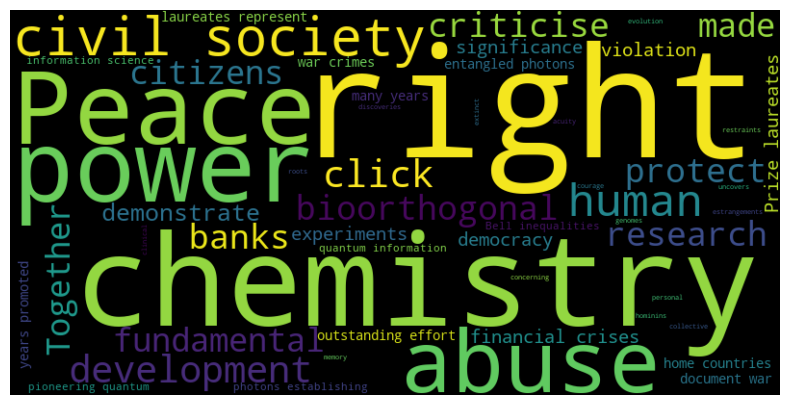

In [2]:
# Function to process motivations and generate a word cloud
def generate_wordcloud(prizes):
    # Combine all motivations into a single string
    motivation_text = " ".join(prize['Motivation'] for prize in prizes)

    # Clean the text by removing non-alphanumeric characters
    motivation_text = re.sub(r'[^\w\s]', '', motivation_text)

    # Create and configure the word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        colormap='viridis',
        max_words=100,
        contour_width=1,
        contour_color='steelblue'
    ).generate(motivation_text)

    return wordcloud

# Function to display the word cloud
def display_wordcloud(wordcloud):
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")  # Hide axes for a cleaner look
    plt.show()

# Main function to run the entire process
def main():
    year = 2022  # Specify the year to fetch data for
    prizes = fetch_nobel_prizes(year)

    if prizes:
        wordcloud = generate_wordcloud(prizes)
        display_wordcloud(wordcloud)

if __name__ == "__main__":
    main()

# Web Scraping

I begin by creating a function to fetch and parse the webpage data.

In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to send a request to a URL and return the BeautifulSoup object
def get_soup(url):
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    
    if response.status_code != 200:
        print(f"Failed to access {url}.")
        return None
    
    return BeautifulSoup(response.text, "html.parser")

Next I create a function to extract details like the title, price, rating, and UPC for each book.

In [4]:
# Function to extract book details from a book item on the main page
def extract_book_details(book, base_url):
    title = book.h3.a["title"]
    price = book.select_one("p.price_color").text.replace("Â", "")
    rating_class = book.select_one("p.star-rating")["class"]
    rating = rating_class[1]
    
    # Extract the relative link to the individual book page
    relative_link = book.h3.a["href"]
    link = f"{base_url}/{relative_link}"
    
    # Scrape the individual book page for additional details like UPC
    book_soup = get_soup(link)
    if book_soup is None:
        return None
    
    upc = book_soup.select_one("table.table.table-striped tr:nth-child(1) td").text

    return {
        "Title": title,
        "Price": price,
        "Rating": rating,
        "UPC": upc,
    }

I then write a function to scrape multiple pages of the website, collecting book data until no more pages are found.

In [5]:
# Function to scrape the books from the website
def scrape_books(base_url, max_pages=3):
    books = []
    page = 1
    
    while page <= max_pages:
        url = f"{base_url}/page-{page}.html"
        soup = get_soup(url)
        
        if soup is None:
            print(f"Failed to access {url}. Stopping scraper.")
            break
        
        book_items = soup.select("article.product_pod")
        
        if not book_items:
            print("No more books to scrape.")
            break
        
        for book in book_items:
            book_details = extract_book_details(book, base_url)
            if book_details:
                books.append(book_details)
        
        print(f"Scraped page {page} successfully.")
        page += 1  # Move to the next page

    return books

The scraped data is organized into a table for easy viewing and analysis.

In [6]:
# Function to convert scraped data to DataFrame
def create_dataframe(books_data):
    return pd.DataFrame(books_data)

Finally I combine all the steps in the main function to run the scraper and display the results.

In [9]:
# Main function to execute the scraper
def main():
    base_url = "https://books.toscrape.com/catalogue"
    books_data = scrape_books(base_url)
    
    if books_data:
        df = create_dataframe(books_data)
        print(df.head())
    else:
        print("No books data found.")

# Run the main function if the script is executed directly
if __name__ == "__main__":
    main()

Scraped page 1 successfully.
Scraped page 2 successfully.
Scraped page 3 successfully.
                                   Title   Price Rating               UPC
0                   A Light in the Attic  £51.77  Three  a897fe39b1053632
1                     Tipping the Velvet  £53.74    One  90fa61229261140a
2                             Soumission  £50.10    One  6957f44c3847a760
3                          Sharp Objects  £47.82   Four  e00eb4fd7b871a48
4  Sapiens: A Brief History of Humankind  £54.23   Five  4165285e1663650f
